## Brain image modeling

### Setup

In [2]:
import shutil
import os
import json
import shutil
import logging
import numpy
import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensor2tensor.utils import trainer_lib
from tensor2tensor import problems
from tensor2tensor.utils import registry
from tensor2tensor.data_generators import allen_brain
from tensor2tensor.data_generators import allen_brain_utils

import tensorflow as tf

from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()
Modes = tf.estimator.ModeKeys

from tk.util import hack_dict_to_cli_args
from tk import experiment
from tk import util

from tensorboard.backend.event_processing import event_file_loader
from protobuf_to_dict import protobuf_to_dict

logging.getLogger().setLevel(logging.INFO)


Instructions for updating:
Use the retry module or similar alternatives.


### TensorBoard

Start a TensorBoard deployment and service pointing to a log_dir parent to all log_dirs we will write for subsequent experiments, allowing us to compare logs from all experiments via a single TensorBoard instance.

In [ ]:
from tk import kube_tensorboard

tb = kube_tensorboard.TensorBoard(log_dir="/mnt/nfs-east1-d/comparisons",
                                  namespace="kubeflow")

tb.create()

### Training

In [3]:

def _stage(local_app_root, remote_app_root):
    if not os.path.exists(local_app_root):
        raise ValueError("Can't stage from a non-existent source, "
                         "saw %s" % local_app_root)
    shutil.copytree(local_app_root, remote_app_root)


def _configure_experiment(base_name, num_gpu_per_worker=1,
                          problem="img2img_allen_brain_dim8to32",
                          batch_size=4,
                          num_steps=100000):

    app_root = "/mnt/nfs-east1-d/work/tk"

    output_dir = os.path.join(app_root, "output")

    job_name = util.generate_job_name(base_name)

    train_args = {
        "problem": problem,
        "model": "img2img_transformer",
        "hparams_set": "img2img_transformer2d_tiny",
        "data_dir": "/mnt/nfs-east1-d/data",
        "output_dir": output_dir,
        "train_steps": num_steps,
        "schedule": "train",
        "profile": False,
        "log_device_placement": False,
        "worker_gpu": num_gpu_per_worker,
        "save_checkpoints_secs": 1800,
        "dbgprofile": False, # Saves profiling timelines, viewable in chrome://tracing
        "ssd_mount_path": "/mnt/disks/ssd0",
        "worker_gpu_memory_fraction": 0.95,
        "hparams": "'batch_size=%s'" % batch_size
    }

    args = {
        "job_name": job_name,
        "volume_claim_id": "nfs-east1-d",
        "app_root": app_root,
        "gcp_project": "foo",
        "namespace": "kubeflow",
        "image": "tensorflow/tensorflow:latest-gpu",
        "smoke": True,
        "batch": False,
        "train_args": train_args,
        "cpu": 7,
        "memory": "40Gi",
        "num_gpu": num_gpu_per_worker,
        "num_local_ssd": 1,
        "no_wait": True,
        "num_worker_replicas": 0,
        "num_ps_replicas": 0,
        "selector_labels": {
          "cloud.google.com/gke-nodepool": "train-gpu-preemptible-%sx-hm" % num_gpu_per_worker,
          "cloud.google.com/gke-accelerator": "nvidia-tesla-k80"
        }
    }

    local_app_root = args["app_root"]

    testing_storage_base = "/mnt/nfs-east1-d/comparisons/%s" % base_name
    remote_app_root = "%s/%s" % (testing_storage_base,
                                 args["job_name"])

    args["train_args"]["output_dir"] = os.path.join(remote_app_root,
                                                    "output")

    with open(os.path.join(local_app_root, "job.sh"), "w") as f:
      f.write("ls /mnt\n")
      f.write("cp -r /mnt/nfs-east1-d/data/* /mnt/ssd0/\n")
      f.write("pip install -e %s/vendor/tensor2tensor\n" % remote_app_root)
      f.write("pip install -e %s\n" % remote_app_root)
      f.write("nvidia-smi\n")
      f.write("python -c 'from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())'\n")
      f.write("echo ${TF_CONFIG}\n")
      f.write("cd %s\n" % remote_app_root)
      cmd = ["python", "-m", "tk.experiment"]
      cmd.extend(hack_dict_to_cli_args(args["train_args"]))
      f.write(" ".join(cmd) + "\n")
      f.write("nvidia-smi\n")
      logging.info(local_app_root)

    _stage(local_app_root, remote_app_root)
    args["app_root"] = remote_app_root
    args["batch"] = True

    return args


In [11]:
comparison_base_name = "example"
args = _configure_experiment(comparison_base_name, batch_size=1)

[2018-07-05 20:40:25,972] /mnt/nfs-east1-d/work/tk


In [12]:
job = experiment.T2TExperiment(**args)
job.run()

[2018-07-05 20:41:29,244] smoke: True


In [18]:
!kubectl logs -n kubeflow example-j0705-2040-9fe3-master-kr9o-0-xw8ww

nfs-east1-d
ssd0
Obtaining file:///mnt/nfs-east1-d/comparisons/example/example-j0705-2040-9fe3/vendor/tensor2tensor
  Running setup.py bdist_wheel for bz2file: started
  Running setup.py bdist_wheel for bz2file: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
  Running setup.py bdist_wheel for future: started
  Running setup.py bdist_wheel for future: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/bf/c9/a3/c538d90ef17cf7823fa51fc701a7a7a910a80f6a405bf15b1a
  Running setup.py bdist_wheel for gym: started
  Running setup.py bdist_wheel for gym: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/cb/14/71/f4ab006b1e6ff75c2b54985c2f98d0644fffe9c1dddc670925
  Running setup.py bdist_wheel for sympy: started
  Running setup.py bdist_wheel for sympy: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/6d/47/7c/40a7cd9b9bd5bad329fcd21d8

### Launch a single-node comparison run

In [4]:

for i in [1, 2, 4]:
  comparison_base_name = "multigpu-4"
  args = _configure_experiment(comparison_base_name, num_gpu_per_worker=i)
  job = experiment.T2TExperiment(**args)
  job.run()


[2018-07-02 19:21:16,814] /mnt/nfs-east1-d/work/tk
[2018-07-02 19:22:25,895] smoke: True
[2018-07-02 19:22:26,024] /mnt/nfs-east1-d/work/tk
[2018-07-02 19:23:32,711] smoke: True
[2018-07-02 19:23:32,839] /mnt/nfs-east1-d/work/tk
[2018-07-02 19:24:41,936] smoke: True
[2018-07-02 19:24:42,072] /mnt/nfs-east1-d/work/tk
[2018-07-02 19:25:48,886] smoke: True


### Visualize comparison results

In [122]:

def _event_dict_list_from_events_file(event_file_path):
    loader = event_file_loader.EventFileLoader(event_file_path)
    events = []
    for event in loader.Load():
      events.append(event)

    output_events = []

    for thing in events:
        d = protobuf_to_dict(thing)

        output_event = {}
        if "wall_time" in d:
            output_event["wall_time"] = d["wall_time"]
        if "step" in d:
            output_event["step"] = d["step"]
        if "summary" in d.keys():
            values = {}
            for value in d["summary"]["value"]:
                if "simple_value" in value.keys():
                    output_event[value["tag"]] = value["simple_value"]

        if "loss" in output_event:
            output_events.append(output_event)
    
    return output_events


def _event_data_for_comparison(comparison_root):
    event_data = []
    tf.logging.info("Identifying event files in experiment subdirectories...")
    paths = tf.gfile.Glob(os.path.join(comparison_root, "*/output/*/events.out*"))
    for i, experiment in enumerate(paths):
        tf.logging.info("Processing experiment events (%s of %s)" % (i + 1, len(paths)))
        event_list = _event_dict_list_from_events_file(experiment)
        event_dict = {"source_path": experiment,
                      "events": event_list}
        # TODO: Also read other experiment metadata
        event_data.append(event_dict)
    tf.logging.info("Finished loading event data for comparison.")
    return event_data


In [123]:

def show_experiment_loss(comparison_base_name):
    
    comparison_root = "/mnt/nfs-east1-d/comparisons/%s" % comparison_base_name
    experiments_data = _event_data_for_comparison(comparison_root)

    plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    for i, experiment_data in enumerate(experiments_data):
        wall_times = [event["wall_time"] for event in experiment_data["events"]]
        minwt = min(wall_times)
        relative_times = [wt - minwt for wt in wall_times]
        losses = [event["loss"] for event in experiment_data["events"]]
        plt.plot(relative_times, losses, label=str(i))

    plt.legend()
    plt.show()


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-06-30 23:51:38,520] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 4)


[2018-06-30 23:51:51,939] Processing experiment events (1 of 4)


INFO:tensorflow:Processing experiment events (2 of 4)


[2018-06-30 23:51:54,049] Processing experiment events (2 of 4)


INFO:tensorflow:Processing experiment events (3 of 4)


[2018-06-30 23:51:58,758] Processing experiment events (3 of 4)


INFO:tensorflow:Processing experiment events (4 of 4)


[2018-06-30 23:52:03,090] Processing experiment events (4 of 4)


INFO:tensorflow:Finished loading event data for comparison.


[2018-06-30 23:52:08,988] Finished loading event data for comparison.


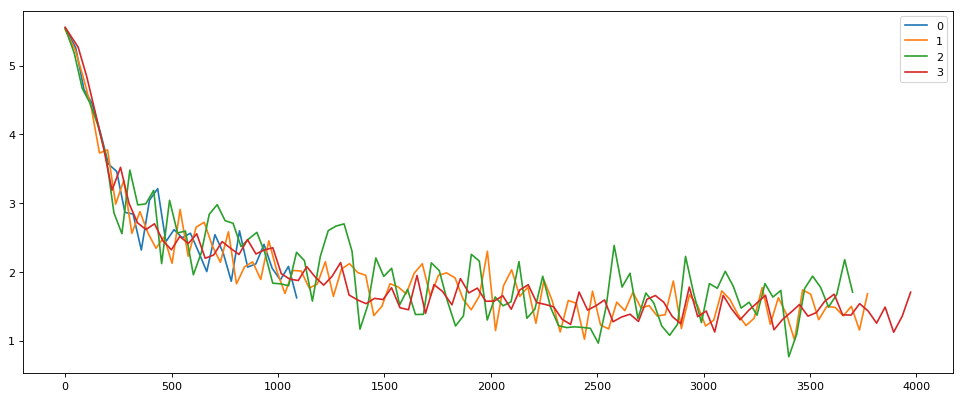

In [19]:

show_experiment_loss("multigpu-2")


In [ ]:

# Blue line was likely preempted

# So looking at this there wasn't a shift in training speed that I expected. Expected the loss
# curve to be more concave with additional GPUs.

# Worth repeating to compare. But do expect optimization to be smoother when processing more
# examples. Also the ability to process more examples is important because it should permit
# dialing back the batch size and increasing the problem size (currently is tiny 8->32px).

# One reason there might not be such a difference between conditions is because the problem
# isn't challenging enough.


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-07-02 20:40:10,296] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 3)


[2018-07-02 20:40:28,413] Processing experiment events (1 of 3)


INFO:tensorflow:Processing experiment events (2 of 3)


[2018-07-02 20:40:33,437] Processing experiment events (2 of 3)


INFO:tensorflow:Processing experiment events (3 of 3)


[2018-07-02 20:40:39,594] Processing experiment events (3 of 3)


INFO:tensorflow:Finished loading event data for comparison.


[2018-07-02 20:40:44,713] Finished loading event data for comparison.


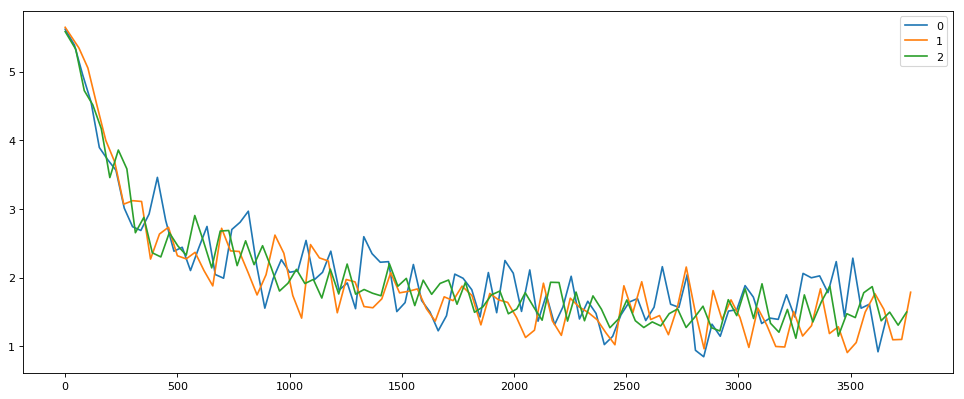

In [13]:

show_experiment_loss("multigpu-4")


In [ ]:

# Again looks to be a smoothing of the 4x condition, as expected.


In [15]:

# Haven't been able to run an 8x job yet - shows added node in cloud dashboard but not via
# kube api


### Launch a multi-node TFJob 

In [35]:

args = _configure_experiment("multinode-2", num_gpu_per_worker=2)
args["num_worker_replicas"] = 0
args["num_ps_replicas"] = 1

job = experiment.T2TExperiment(**args)
job.run()


[2018-07-02 18:53:46,667] /mnt/nfs-east1-d/work/tk
[2018-07-02 18:54:53,304] smoke: True


In [ ]:

show_experiment_loss("multinode-2")


### Larger problem

Checking whether we can run the larger problem at reduced or increased batch sizes without failing with GPU OOM.

In [13]:

for batch_size in [1, 2, 4, 8, 16]:

    args = _configure_experiment("larger-b%s" % batch_size,
                                 problem="img2img_allen_brain_dim48to64",
                                 num_gpu_per_worker=1,
                                 batch_size=batch_size)

    job = experiment.T2TExperiment(**args)
    job.run()


[2018-07-02 23:14:49,768] /mnt/nfs-east1-d/work/tk
[2018-07-02 23:16:03,244] smoke: True
[2018-07-02 23:16:03,392] /mnt/nfs-east1-d/work/tk
[2018-07-02 23:17:14,189] smoke: True
[2018-07-02 23:17:14,319] /mnt/nfs-east1-d/work/tk
[2018-07-02 23:18:25,418] smoke: True
[2018-07-02 23:18:25,542] /mnt/nfs-east1-d/work/tk
[2018-07-02 23:19:37,799] smoke: True
[2018-07-02 23:19:37,921] /mnt/nfs-east1-d/work/tk
[2018-07-02 23:20:52,217] smoke: True


In [ ]:

# All of the above conditions either crashed or were evicted except the batch_size=1 condition,
# presumably because of the intersection of the problem size, batch size, and limited size of K80
# GPU memory.

# Also b_size=[4, 8, and 16] still fail with n_gpu=4


### Inference

In [4]:
hparams_set = "img2img_transformer2d_tiny"
problem_name = "img2img_allen_brain_dim8to32"
model_name = "img2img_transformer"
data_dir = "/mnt/nfs-east1-d/data"

In [5]:
hp = trainer_lib.create_hparams(
    hparams_set,
    data_dir=data_dir,
    problem_name=problem_name)

model = registry.model(model_name)(hp, Modes.TRAIN)

problem_object = problems.problem(problem_name)

dataset = problem_object.dataset(Modes.TRAIN, data_dir)

INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-07-09 17:26:22,095] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain_dim8to32-train*


[2018-07-09 17:26:22,100] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain_dim8to32-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-07-09 17:26:22,165] partition: 0 num_data_files: 100


In [73]:
for count, example in enumerate(tfe.Iterator(dataset)):
    # Get the 100th example, skipping background
    if count > 100:
        break

In [74]:

# TODO: Examples don't appear to be shuffled propperly! (The first 1725 are background)


In [75]:
example["inputs"] = tf.reshape(example["inputs"], [1, 8, 8, 3])
example["targets"] = tf.reshape(example["targets"], [1, 32, 32, 3])

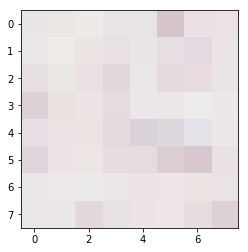

In [76]:
plt.imshow(example["inputs"].numpy()[0])

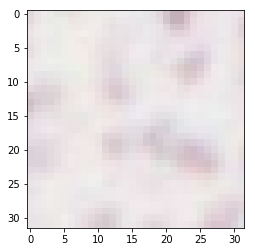

In [77]:
plt.imshow(example["targets"].numpy()[0])

In [78]:
example["inputs"].numpy()[0]

array([[[234, 230, 231],
        [235, 232, 228],
        [238, 234, 232],
        [233, 229, 231],
        [231, 227, 231],
        [213, 196, 204],
        [235, 224, 229],
        [234, 226, 230]],

       [[235, 231, 231],
        [239, 236, 232],
        [236, 229, 228],
        [232, 224, 228],
        [234, 229, 233],
        [230, 222, 227],
        [227, 217, 226],
        [235, 228, 229]],

       [[230, 224, 227],
        [233, 232, 229],
        [234, 226, 226],
        [225, 216, 221],
        [234, 232, 230],
        [229, 218, 219],
        [232, 220, 224],
        [234, 228, 230]],

       [[220, 209, 214],
        [233, 226, 225],
        [237, 229, 229],
        [229, 220, 223],
        [236, 231, 234],
        [235, 231, 233],
        [237, 235, 236],
        [236, 231, 233]],

       [[232, 222, 229],
        [236, 227, 229],
        [236, 228, 227],
        [227, 218, 221],
        [218, 210, 217],
        [221, 216, 222],
        [229, 225, 232],
        [235, 232

In [79]:
example["targets"].numpy()[0]

array([[[225, 216, 219],
        [233, 228, 230],
        [238, 235, 234],
        ...,
        [238, 232, 236],
        [236, 228, 234],
        [236, 224, 233]],

       [[227, 218, 221],
        [234, 228, 230],
        [237, 234, 233],
        ...,
        [236, 231, 235],
        [234, 226, 231],
        [228, 216, 222]],

       [[234, 225, 228],
        [238, 232, 234],
        [239, 237, 235],
        ...,
        [236, 231, 235],
        [233, 225, 230],
        [223, 211, 218]],

       ...,

       [[234, 229, 233],
        [236, 232, 233],
        [237, 233, 232],
        ...,
        [220, 204, 211],
        [217, 204, 212],
        [222, 213, 219]],

       [[232, 227, 231],
        [233, 229, 230],
        [234, 230, 229],
        ...,
        [219, 200, 209],
        [216, 205, 213],
        [224, 219, 225]],

       [[232, 227, 231],
        [233, 229, 230],
        [234, 230, 229],
        ...,
        [217, 199, 209],
        [219, 209, 217],
        [224, 223, 228]]

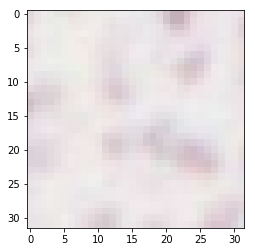

In [80]:
plt.imshow(example["targets"].numpy()[0])

In [81]:
example2 = example
example2["targets"] = tf.reshape(tf.zeros((1, 32, 32, 3), dtype=np.uint8), [1, 32, 32, 3])

In [82]:
ckpt_path = "/mnt/nfs-east1-d/comparisons/multigpu-4/multigpu-4-j0702-1923-8c15/output/master-0/model.ckpt-10000"
with tfe.restore_variables_on_create(ckpt_path):
  predictions, _ = model(example2)

In [6]:
import numpy as np

def infer(predictions):
    p = predictions.numpy()
    x_max = p.shape[1] # X-position in image
    y_max = p.shape[2] # Y-position in image
    c_max = p.shape[3] # Color channel (r,g,b)

    # The image we will populate
    image = np.zeros((1, x_max, y_max, c_max), dtype=np.uint8)

    batch_idx = 0

    for x in range(0, x_max):
        for y in range(0, y_max):
            for c in range(0, c_max):
                # Get the index of the greatest value in p[0][x][y][c]
                val = np.argmax(p[0][x][y][c])
                image[batch_idx][x][y][c] = np.uint8(np.argmax(p[0][x][y][c]))
    return image[0]


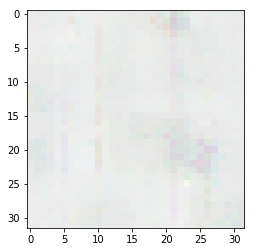

In [86]:
with tfe.restore_variables_on_create(ckpt_path):
  predictions, _ = model(example2)
  plt.imshow(infer(predictions))

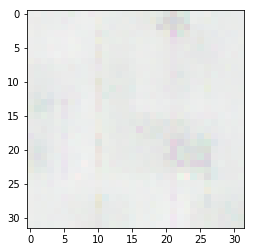

In [87]:
with tfe.restore_variables_on_create(ckpt_path):
  predictions, _ = model(example2)
  plt.imshow(infer(predictions))

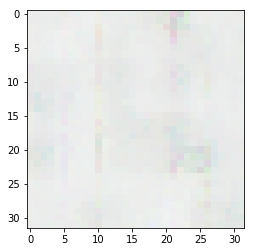

In [88]:
with tfe.restore_variables_on_create(ckpt_path):
  predictions, _ = model(example2)
  plt.imshow(infer(predictions))

In [3]:
def _predict_ith(offset):
    with tfe.restore_variables_on_create(ckpt_path):
      for count, example in enumerate(tfe.Iterator(dataset)):
          if count > offset:
            break
      fig=plt.figure(figsize=(8, 8))
      example["inputs"] = tf.reshape(example["inputs"], [1, 8, 8, 3])
      fig.add_subplot(1, 3, 1)
      plt.imshow(example["inputs"].numpy()[0])
      fig.add_subplot(1, 3, 2)
      example["targets"] = tf.reshape(example["targets"], [1, 32, 32, 3])
      plt.imshow(example["targets"].numpy()[0])
      example["targets"] = tf.reshape(tf.zeros((1, 32, 32, 3), dtype=np.uint8), [1, 32, 32, 3])
      predictions, _ = model(example)
      fig.add_subplot(1,3,3)
      plt.imshow(infer(predictions))
      plt.show()

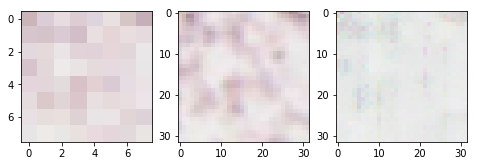

In [116]:
_predict_ith(1724)

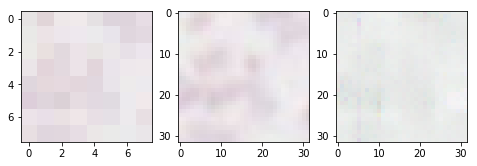

In [111]:
_predict_ith(1726)

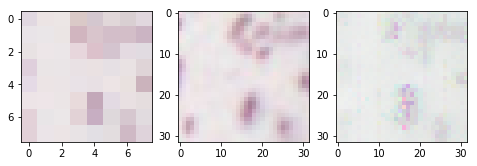

In [112]:
_predict_ith(1727)

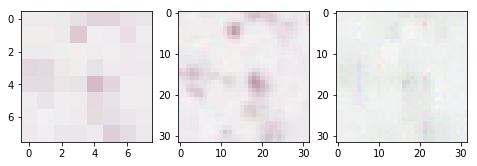

In [113]:
_predict_ith(1728)

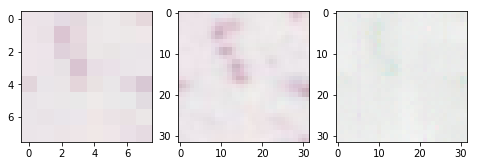

In [117]:
_predict_ith(1729)

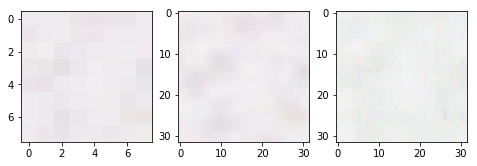

In [119]:
_predict_ith(1730)

In [211]:
# Getting there! 🎉

### Long run

In [121]:
comparison_base_name = "longrun-1"
args = _configure_experiment(comparison_base_name, num_gpu_per_worker=4, num_steps=100000)
job = experiment.T2TExperiment(**args)
job.run()

[2018-07-06 03:12:13,561] /mnt/nfs-east1-d/work/tk
[2018-07-06 03:13:18,151] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-07-06 17:13:12,970] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 2)


[2018-07-06 17:13:19,645] Processing experiment events (1 of 2)


INFO:tensorflow:Processing experiment events (2 of 2)


[2018-07-06 17:13:56,011] Processing experiment events (2 of 2)


INFO:tensorflow:Finished loading event data for comparison.


[2018-07-06 17:14:00,014] Finished loading event data for comparison.


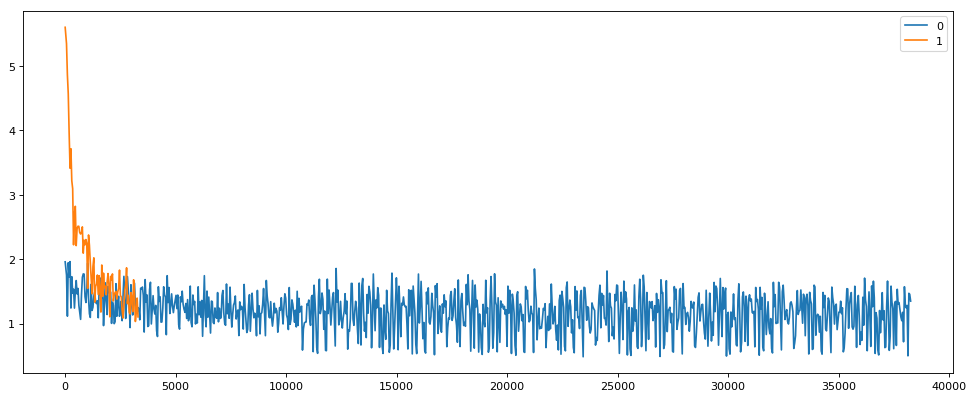

In [124]:

show_experiment_loss("longrun-1")


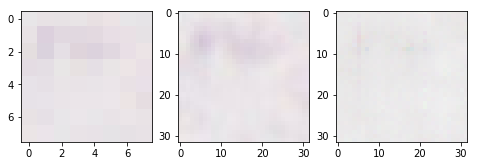

In [9]:

ckpt_path = "/mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/model.ckpt-100000"
_predict_ith(1724)


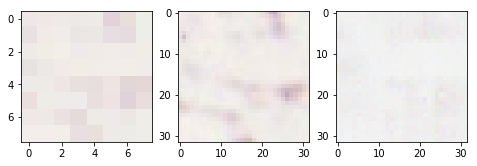

In [17]:

ckpt_path = "/mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/model.ckpt-100000"
_predict_ith(1000)


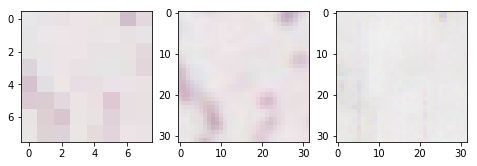

In [18]:

ckpt_path = "/mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/model.ckpt-100000"
_predict_ith(1000)


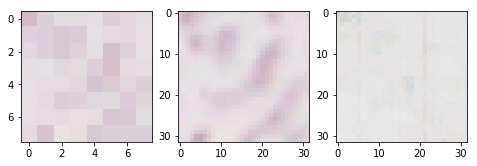

In [22]:

ckpt_path = "/mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/model.ckpt-100000"
_predict_ith(1700)



These inferred images look more pink and more smooth and not entirely unlike blurry microscopy images. Streaks are present here as well. Likely using an adversarial loss will clarify these.

Wondering whether this is the best training dataset given the target images are themselves somewhat blurry.


In [30]:
# What happened at the end of our run?
!tail -n 40 /mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/master-0-logs.txt

loss = 1.2469343, step = 99451 (39.952 sec)
global_step/sec: 2.50104
loss = 1.2852725, step = 99551 (39.984 sec)
global_step/sec: 2.49111
loss = 0.5020779, step = 99651 (40.149 sec)
global_step/sec: 2.48948
loss = 1.4723905, step = 99751 (40.162 sec)
global_step/sec: 2.49531
loss = 1.4562203, step = 99851 (40.075 sec)
global_step/sec: 2.48636
loss = 1.3510604, step = 99951 (40.227 sec)
Saving checkpoints for 100000 into /mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/model.ckpt.
Loss for final step: 1.4526024.
Overriding hparams in img2img_transformer2d_tiny with batch_size=4
From /mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/vendor/tensor2tensor/tensor2tensor/utils/trainer_lib.py:150: __init__ (from tensorflow.contrib.learn.python.learn.estimators.run_config) is deprecated and will be removed in a future version.
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
schedule=train
wo

### Large image up-sampling by padded tiling

#### Load and display raw (target) image

In [7]:
from PIL import Image

# Showing large image
raw_image_path = "/mnt/nfs-east1-d/allen/small/raw/100142550/102173175/raw_102173175.jpg"

img = Image.open(raw_image_path)
img = np.float32(img)
shape = np.shape(img)
shape

/home/jovyan/.conda/envs/py2/lib/python2.7/site-packages/PIL/Image.py:2546: DecompressionBombWarning: Image size (91445760 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


(7776, 11760, 3)

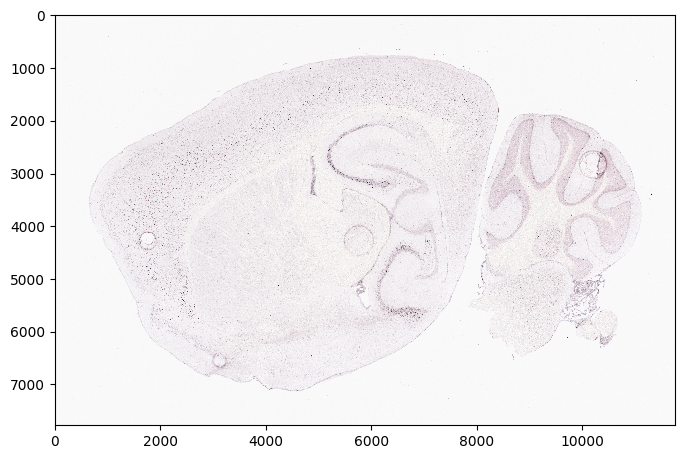

In [21]:
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.uint8(img))

(511, 511, 3)

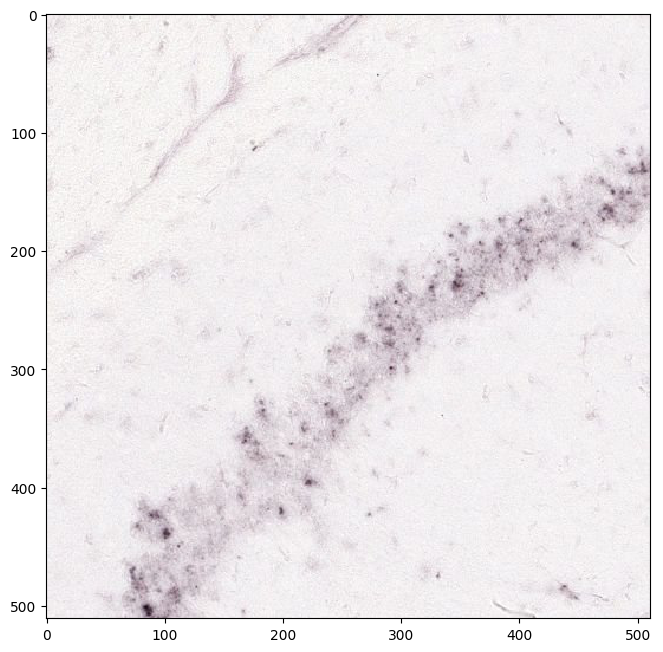

In [6]:
size = 512

h_index = 4
v_index = 10

h_offset = h_index * size
h_end = h_offset + size - 1

v_offset = v_index * size
v_end = v_offset + size - 1

target_image = np.uint8(img[h_offset:h_end, v_offset:v_end])

plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')

plt.imshow(target_image)
np.shape(target_image)

#### Downsample to generate input image

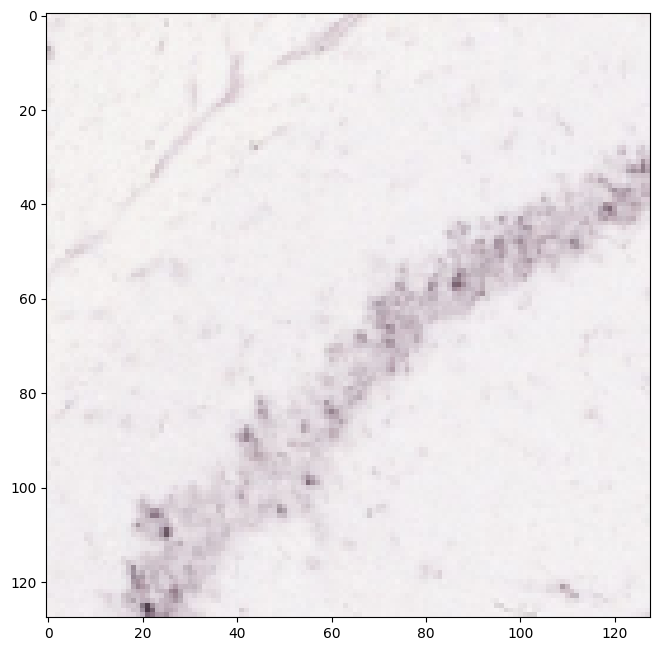

In [7]:
from tensor2tensor.data_generators import image_utils
input_image = image_utils.resize_by_area(target_image, 128).numpy()
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(input_image)

In [8]:

from tensor2tensor.data_generators import image_utils

def get_and_downsample_images(img, size, h_index, v_index):

    h_offset = h_index * size
    h_end = h_offset + size - 1

    v_offset = v_index * size
    v_end = v_offset + size - 1

    target_image = np.uint8(img[h_offset:h_end, v_offset:v_end])

    input_image = image_utils.resize_by_area(target_image, 128).numpy()
    
    return input_image, target_image


#### Loop over 8x8 patches, inferring 32x32 output (with overlap)

In [9]:
ckpt_path = "/mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/model.ckpt-100000"

In [10]:

# Currently with no overlap

def patchwise_infer(input_image, ckpt_path, target_shape):
    
    target_image = np.zeros(target_shape, dtype=np.uint8)
    
    input_shape = np.shape(input_image)

    input_stride = 8
    input_padding = 2
    target_stride = 32

    with tfe.restore_variables_on_create(ckpt_path):

        x_index_max = input_shape[0] // input_stride
        for x_index in range(0, x_index_max):
            
            tf.logging.info("processing row %s of %s" % (
                x_index, x_index_max))

            for y_index in range(0, input_shape[1] // input_stride):

                example = {}

                input_x_start = x_index * input_stride
                input_x_end = input_x_start + input_stride
                input_y_start = y_index * input_stride
                input_y_end = input_y_start + input_stride

                input_patch = input_image[input_x_start:input_x_end,
                                          input_y_start:input_y_end]

                example["inputs"] = tf.reshape(input_patch, [1, 8, 8, 3])

                example["targets"] = tf.reshape(tf.zeros((1, 32, 32, 3),
                                                         dtype=np.uint8),
                                                [1, 32, 32, 3])

                predictions, _ = model(example)

                target_x_start = x_index * target_stride
                target_y_start = y_index * target_stride
                target_x_end = target_x_start + target_stride
                target_y_end =  target_y_start + target_stride

                prediction = infer(predictions)

                try:
                  target_image[target_x_start:target_x_end,
                               target_y_start:target_y_end] = prediction
                except:
                    tf.logging.info("Ran out of space in target, skipping...")

    return target_image

INFO:tensorflow:processing row 0 of 16


[2018-07-09 17:27:42,802] processing row 0 of 16


INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-07-09 17:27:42,808] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-07-09 17:27:42,809] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-07-09 17:27:42,811] Building model body


INFO:tensorflow:Transforming body output with identity_modality.top


[2018-07-09 17:27:43,866] Transforming body output with identity_modality.top


INFO:tensorflow:processing row 1 of 16


[2018-07-09 17:27:57,906] processing row 1 of 16


INFO:tensorflow:processing row 2 of 16


[2018-07-09 17:28:13,029] processing row 2 of 16


INFO:tensorflow:processing row 3 of 16


[2018-07-09 17:28:28,379] processing row 3 of 16


INFO:tensorflow:processing row 4 of 16


[2018-07-09 17:28:43,571] processing row 4 of 16


INFO:tensorflow:processing row 5 of 16


[2018-07-09 17:28:59,169] processing row 5 of 16


INFO:tensorflow:processing row 6 of 16


[2018-07-09 17:29:14,554] processing row 6 of 16


INFO:tensorflow:processing row 7 of 16


[2018-07-09 17:29:31,631] processing row 7 of 16


INFO:tensorflow:processing row 8 of 16


[2018-07-09 17:29:46,817] processing row 8 of 16


INFO:tensorflow:processing row 9 of 16


[2018-07-09 17:30:01,966] processing row 9 of 16


INFO:tensorflow:processing row 10 of 16


[2018-07-09 17:30:17,379] processing row 10 of 16


INFO:tensorflow:processing row 11 of 16


[2018-07-09 17:30:32,764] processing row 11 of 16


INFO:tensorflow:processing row 12 of 16


[2018-07-09 17:30:47,974] processing row 12 of 16


INFO:tensorflow:processing row 13 of 16


[2018-07-09 17:31:03,192] processing row 13 of 16


INFO:tensorflow:processing row 14 of 16


[2018-07-09 17:31:18,532] processing row 14 of 16


INFO:tensorflow:processing row 15 of 16


[2018-07-09 17:31:33,899] processing row 15 of 16


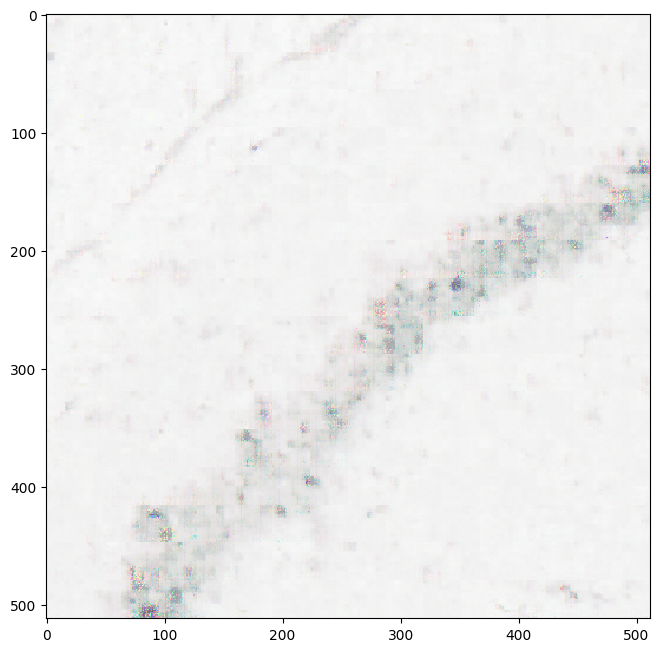

In [11]:
# Large image

input_image, target_image = get_and_downsample_images(img, 512, 4, 10)
inferred = patchwise_infer(input_image, ckpt_path, (512, 512, 3))
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(inferred)


In [1]:
# Cool! So there's work to be done but again this does not look entirely unlike the target image.
# Could really benefit from overlapping.

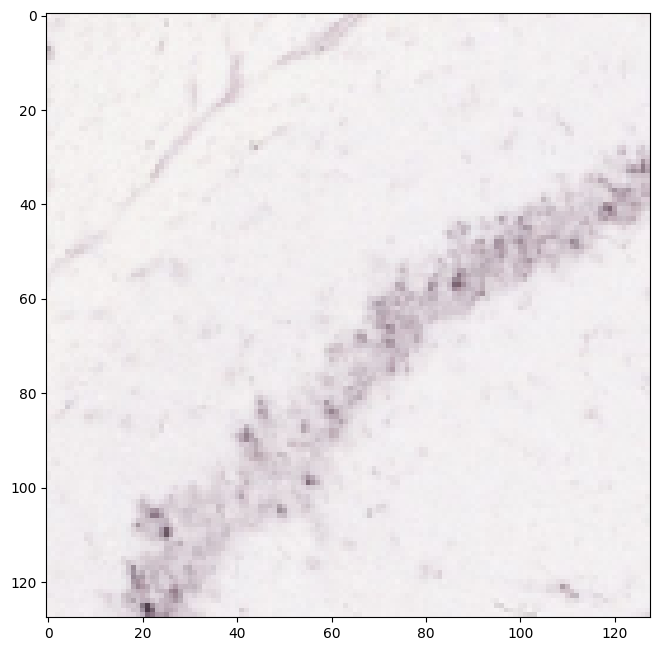

In [150]:
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(input_image)

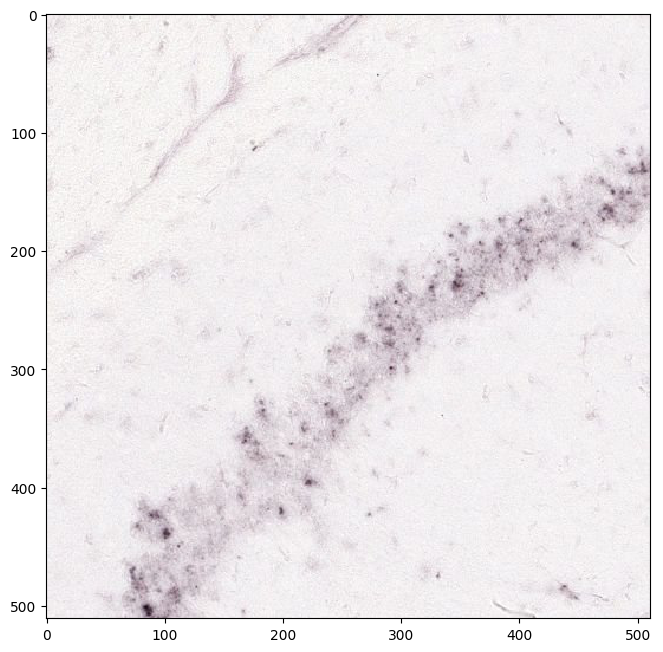

In [149]:
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(target_image)

### Resource usage during the above long training run?

In [15]:
# This is logged to resources_log.txt in training dir by background process
!tail -n 100 /mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/resources_log.txt

| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:08.0 Off |                    0 |
| N/A   73C    P0   139W / 149W |  11001MiB / 11439MiB |     73%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:00:09.0 Off |                    0 |
| N/A   73C    P0   137W / 149W |  11001MiB / 11439MiB |     89%      Default |
+-------------------------------+----------------------+----------------------+
|   2  Tesla K80           Off  | 00000000:00:0A.0 Off |                    0 |
| N/A   72C    P0   146W / 149W |  11001MiB / 11439MiB |     83%      Default |
+-------------------------------+----------------------+----------------------+
|   3  Tesla K80           Off  | 000000

In [ ]:
import json

def resource_log_to_events(log_path):
    with open(log_path, "r") as f:
        for line in f:
            if line.startswith("{"):
                d = json.loads(line)
                print(d)

log_path = "/mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/resources_log.txt"
resource_log_to_events(log_path)

# Resource logger should be revised to write json.loads-able output.

### Long run of larger problem (with smaller upscaling factor)

In [13]:
batch_size = 1

args = _configure_experiment("d48to64-b%s" % batch_size,
                             problem="img2img_allen_brain_dim48to64",
                             num_gpu_per_worker=4,
                             batch_size=batch_size,
                             num_steps=10000)

job = experiment.T2TExperiment(**args)
job.run()

[2018-07-09 17:56:46,448] /mnt/nfs-east1-d/work/tk
[2018-07-09 17:57:53,551] smoke: True


In [ ]:
# The larger problem is about 4x slower than the smaller one (~0.45 step/sec)

### Next/future

In [ ]:
# Parllel inference?
# Curious about image standardization and batch norm

# GPUs with more memory would help run larger batches
# K80: 12
# P/V100: 16